In [3]:
import os
import re
import json
import zipfile
import urllib.request
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
import re
import numpy as np

# NLTK resources (Colab / new nltk)
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
INPUT_CSV = "/content/drive/MyDrive/FOX_DTM_Analysis_Results.csv"

In [6]:
!pip -q install regex
import regex as re2

In [7]:
def extract_emojis(s):
    return re2.findall(r"\p{Emoji_Presentation}|\p{Extended_Pictographic}", str(s))

def clean_text(s: str) -> str:
    s = str(s).lower()
    # per your requirement: lowercase + remove punctuation/special chars
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def penn_to_wn(tag: str):
    # keep only noun/verb/adj (per your requirement)
    if tag.startswith("NN"):
        return NOUN
    if tag.startswith("VB"):
        return VERB
    if tag.startswith("JJ"):
        return ADJ
    return None

# Stopwords: remove get/got to avoid killing imperative phrases like "get out"
BASE_STOP = set(stopwords.words("english"))
EXTRA_STOP = {
    "will","would","this","that","these","those","there","here","also","just",
    "like","one","u","ur","im","youre","hes","shes","theyre","weve",
    "amp","lol","lmao","omg","dont","doesnt","didnt","cant","wont","isnt","arent",
    "ive","id","youve","youd","theyve","theyd","whats","thats","theres","heres",
    "rt","via"
}
STOP = BASE_STOP.union(EXTRA_STOP)

LEMM = WordNetLemmatizer()

# Strong keep list: never dropped even if POS/stopword would remove it
SLANG_KEEP = {"fafo", "acab", "fjb", "maga", "dhs", "ice"}

# Phrase merge: preserve stance-carrying imperative phrases
PHRASES = {
    ("get", "out"),
    ("go", "back"),
    ("send", "back"),
    ("ice", "out"),
    ("kick", "out"),
    ("lock", "up"),
}

def merge_phrases(tokens):
    i, merged = 0, []
    while i < len(tokens):
        if i + 1 < len(tokens) and (tokens[i], tokens[i+1]) in PHRASES:
            merged.append(tokens[i] + "_" + tokens[i+1])
            i += 2
        else:
            merged.append(tokens[i])
            i += 1
    return merged

def preprocess_comment(text: str):
    """
    EXACT required order:
    clean -> NLTK tokenize -> POS filter (N/V/Adj) -> lemmatize -> extended stopwords
    Output: list of effective tokens
    """
    t = clean_text(text)
    tokens = word_tokenize(t)
    tokens = merge_phrases(tokens)  # still in tokenization stage
    tagged = pos_tag(tokens)

    out = []
    for w, tag in tagged:
        w = w.lower()

        # strong keep first (prevents information loss like "fafo")
        if w in SLANG_KEEP:
            out.append(w)
            continue

        wn_pos = penn_to_wn(tag)
        if wn_pos is None:
            continue

        if w in STOP:
            continue

        lemma = LEMM.lemmatize(w, pos=wn_pos)
        if lemma and lemma not in STOP and len(lemma) > 1:
            out.append(lemma)

    return out

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    if a is None or b is None:
        return -1.0
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return -1.0
    return float(np.dot(a, b) / (na * nb))

def contains_phrase(text_clean: str, phrase: str) -> bool:
    return re.search(rf"\b{re.escape(phrase)}\b", text_clean) is not None

In [8]:

# Step 1: Load data + filter angry comments


if not os.path.exists(INPUT_CSV):
    # allow running when file is in current working dir
    INPUT_CSV = "CNN_DTM_Analysis_Results.csv"
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError("Cannot find CNN_DTM_Analysis_Results.csv. Upload it to Colab (Files) root or /content/.")

df = pd.read_csv(INPUT_CSV)

# Auto-detect columns
# emotion column candidates
emotion_candidates = [c for c in df.columns if c.lower() in ["emotion", "sentiment", "label"]]
# text column candidates
text_candidates = [c for c in df.columns if c.lower() in ["comment_text","comment","text","body","content","message"]]

if not emotion_candidates:
    raise ValueError(f"Cannot find emotion column. Existing columns: {list(df.columns)}")
if not text_candidates:
    raise ValueError(f"Cannot find text column. Existing columns: {list(df.columns)}")

emotion_col = emotion_candidates[0]
text_col = text_candidates[0]

anger_df = df[df[emotion_col].astype(str).str.lower() == "anger"].copy()
anger_df.reset_index(drop=True, inplace=True)

print(f"[Step1] emotion_col={emotion_col}, text_col={text_col}")
print(f"[Step1] Total angry comments: {len(anger_df)}")

# Preprocess all angry comments (no skipping)
tokens_list = []
vocab = set()

for txt in anger_df[text_col].astype(str).tolist():
    toks = preprocess_comment(txt)
    tokens_list.append(toks)
    vocab.update(toks)

anger_df["tokens"] = tokens_list
print(f"[Step1] Vocab size after preprocessing: {len(vocab)}")



[Step1] emotion_col=emotion, text_col=comment_text
[Step1] Total angry comments: 41376
[Step1] Vocab size after preprocessing: 18254


In [9]:
anger_df["tokens"] = anger_df["comment_text"].astype(str).apply(preprocess_comment)


In [10]:
fafo_cnt = sum("fafo" in set(t) for t in anger_df["tokens"])
print("comments containing fafo:", fafo_cnt)

for p in ["get_out","go_back","send_back","ice_out"]:
    c = sum(p in set(t) for t in anger_df["tokens"])
    print(p, "comments:", c)

anger_df["emoji_seq"] = anger_df["comment_text"].apply(extract_emojis)
print("comments with emoji:", (anger_df["emoji_seq"].apply(len) > 0).mean())

comments containing fafo: 243
get_out comments: 340
go_back comments: 67
send_back comments: 1
ice_out comments: 32
comments with emoji: 0.0939916860015468


In [11]:
# Step 2
import os, zipfile, urllib.request

GLOVE_ZIP_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "/content/glove.6B.zip"
GLOVE_TXT = "/content/glove.6B.300d.txt"

def is_valid_zip(path):
    if not os.path.exists(path):
        return False
    try:
        with zipfile.ZipFile(path, "r") as z:
            bad = z.testzip()
            return bad is None
    except Exception:
        return False

def download_glove():
    # already extracted
    if os.path.exists(GLOVE_TXT):
        print("[Step2] GloVe txt already exists:", GLOVE_TXT)
        return

    # zip exists but broken -> delete
    if os.path.exists(GLOVE_ZIP) and (not is_valid_zip(GLOVE_ZIP)):
        print("[Step2] Found corrupted zip, deleting:", GLOVE_ZIP)
        os.remove(GLOVE_ZIP)

    # download zip if needed
    if not os.path.exists(GLOVE_ZIP):
        print("[Step2] Downloading GloVe zip...")
        urllib.request.urlretrieve(GLOVE_ZIP_URL, GLOVE_ZIP)

    # validate again
    if not is_valid_zip(GLOVE_ZIP):
        # if still invalid, delete and hard-fail
        os.remove(GLOVE_ZIP)
        raise RuntimeError("[Step2] Downloaded file is still not a valid zip. Re-run this cell to retry.")

    # extract 300d
    print("[Step2] Extracting glove.6B.300d.txt ...")
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extract("glove.6B.300d.txt", path="/content")

download_glove()


[Step2] GloVe txt already exists: /content/glove.6B.300d.txt


In [12]:
KW_LOCAL = set("""
mayor governor city state council cityhall
walz frey minneapolis minnesota mn
""".split())

In [13]:
def comment_embedding(tokens):
    vecs = [glove[w] for w in tokens if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(300)

In [14]:
import numpy as np

def load_glove_300d(glove_txt_path: str, dim: int = 300):
    glove = {}
    with open(glove_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] != dim:
                continue
            glove[word] = vec
    return glove

glove = load_glove_300d(GLOVE_TXT, dim=300)

def comment_embedding(tokens, dim=300):
    vecs = [glove[w] for w in tokens if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim, dtype=np.float32)

print("[Step2] glove loaded:", len(glove))


[Step2] glove loaded: 400000


In [15]:
import numpy as np

def mean_vec(words, dim=300):
    vecs = [glove[w] for w in words if w in glove]
    return np.mean(vecs, axis=0).astype(np.float32) if vecs else np.zeros(dim, dtype=np.float32)

# A) ICE centroid for semantic gating / similarity
ICE_SEED = ["ice","dhs","ero","deport","deportation","immigration","border","enforcement","raid"]
ice_centroid = mean_vec(ICE_SEED)

# B) Prototypes used inside classify_anger_object (soft evidence)
proto_ice = mean_vec(["ice","dhs","deportation","immigration","border"])
proto_trump = mean_vec(["trump","donald","president","maga"])
proto_localgov = mean_vec(["mayor","governor","city","state","minneapolis"])
proto_immig = mean_vec(["immigrant","immigration","migrant","asylum","refugee","undocumented","illegal"])
proto_indirect = mean_vec(["corrupt","corruption","justice","court","system","government","law","rights","unconstitutional"])

print("[Step2.5] ice_centroid/prototypes ready.",
      "ice_centroid_norm=", float(np.linalg.norm(ice_centroid)))


[Step2.5] ice_centroid/prototypes ready. ice_centroid_norm= 3.495305299758911


In [16]:
# ---- Keyword sets required by classify_anger_object ----

KW_VICTIM = set("""
victim killed shot shooter murder murdered murdered
""".split())

KW_LOCAL = set("""
mayor governor city state council official officials frey walz minneapolis
""".split())

KW_ICE = set("""
ice dhs ero deport deportation immigration immigrant immigrants border enforcement raid
""".split())

KW_RESIST = set("""
sanctuary resist resisting refusal refuse defy defying block blocked obstruct
""".split())

KW_SUPPORT = set("""
support cooperate cooperating assist helping aid back backed endorse
""".split())

KW_TRUMP = set("""
trump donald maga president
""".split())

KW_INDIRECT = set("""
corrupt corruption justice court system government law laws unconstitutional tyranny rights abuse
""".split())

KW_IMMIG = set("""
immigration immigrant immigrants migrant migrants asylum refugee refugees undocumented illegal illegals alien aliens
""".split())


In [17]:
# Robust GloVe download (self-healing)

def is_valid_zip(path):
    if not os.path.exists(path):
        return False
    try:
        with zipfile.ZipFile(path, "r") as z:
            return z.testzip() is None
    except Exception:
        return False


def download_glove():
    if os.path.exists(GLOVE_TXT):
        return

    # Delete corrupted zip file
    if os.path.exists(GLOVE_ZIP) and (not is_valid_zip(GLOVE_ZIP)):
        print("[Step2] Found corrupted zip, deleting:", GLOVE_ZIP)
        os.remove(GLOVE_ZIP)

    if not os.path.exists(GLOVE_ZIP):
        print("[Step2] Downloading GloVe (glove.6B.zip)...")
        urllib.request.urlretrieve(GLOVE_ZIP_URL, GLOVE_ZIP)

    if not is_valid_zip(GLOVE_ZIP):
        # Force retry in next execution
        os.remove(GLOVE_ZIP)
        raise RuntimeError("[Step2] Downloaded glove.6B.zip is not a valid zip. Re-run this cell to retry.")

    print("[Step2] Extracting glove.6B.300d.txt ...")
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extract("glove.6B.300d.txt", path="/content")


download_glove()


def classify_anger_object(raw_text: str, tokens: list, emb: np.ndarray, sim_ice: float):
    tclean = clean_text(raw_text)
    tokset = set(tokens)

    # Victim-related keywords
    KW_VICTIM = {"victim", "killed", "shot", "murdered", "innocent", "her", "she"}

    # Renee Good detection
    renee_mentioned = "renee" in tokset or "renee" in tclean
    fafo_mentioned = "fafo" in tokset or "find out" in tclean

    # Handle Renee Good first (highest priority)
    if renee_mentioned:
        if fafo_mentioned:
            return "①ICE agency"  # Criticism camp → Pro-enforcement
        elif any(w in tokset for w in KW_VICTIM):
            return "⑤Victim (Renee Good)"  # Sympathy camp
        else:
            return "⑤Victim (Renee Good)"  # Default: sympathy

    has_local = (len(tokset & KW_LOCAL) > 0)

    # ICE-related keywords
    has_ice_agency = any(word in tokset for word in ["ice", "dhs", "ero"])
    has_immig_topic = any(word in tokset for word in [
        "immigration", "immigrant", "border",
        "deport", "illegal", "undocumented"
    ])

    # Political figures
    has_biden = "biden" in tokset
    has_trump = (len(tokset & KW_TRUMP) > 0) or "trump" in tclean

    resist_cue = len(tokset & KW_RESIST) > 0 or any(
        contains_phrase(tclean, p) for p in ["sanctuary city", "sanctuary state"]
    )
    support_cue = len(tokset & KW_SUPPORT) > 0
    has_indirect = len(tokset & KW_INDIRECT) > 0

    # Soft semantic similarity evidence
    s_ice = cosine(emb, proto_ice)
    s_trump = cosine(emb, proto_trump)
    s_local = cosine(emb, proto_localgov)
    s_immig = cosine(emb, proto_immig)
    s_ind = cosine(emb, proto_indirect)

    # Priority order
    # 1. Political figure + immigration topic
    if (has_biden or has_trump) and has_immig_topic:
        return "②Trump"

    # 2. Pure immigration discussion
    if has_immig_topic and not has_ice_agency and not (has_biden or has_trump):
        return "⑥Undocumented immigrants"

    # 3. Local government
    if has_local:
        return "③Local government"

    # 4. ICE agency
    if has_ice_agency or (s_ice >= 0.45 and sim_ice >= 0.4):
        return "①ICE agency"

    # 5. Trump
    if has_trump or (s_trump >= 0.45):
        return "②Trump"

    # 6. Corruption / system-level anger
    if has_indirect and (sim_ice >= 0.4 or s_ind >= 0.45):
        return "⑦Corruption / justice-system / government failures"
    if (s_ind >= 0.50 and sim_ice >= 0.4):
        return "⑦Corruption / justice-system / government failures"

    # 7. Pure emotional venting
    tok_len = len(tokens)
    if (
        sim_ice < 0.25 and
        tok_len <= 2 and
        not (has_trump or has_local or has_ice_agency or has_immig_topic or has_indirect)
    ):
        return "⑧Pure emotional venting"

    # 8. Similarity-based fallback
    candidates = {
        "①ICE agency": s_ice,
        "②Trump": s_trump,
        "⑥Undocumented immigrants": s_immig,
        "⑦Corruption / justice-system / government failures": s_ind
    }

    best_obj, best_score = max(
        candidates.items(),
        key=lambda x: x[1] if x[1] is not None else -1.0
    )

    if best_score is not None and best_score >= 0.40:
        return best_obj

    return "⑧Pure emotional venting"


In [18]:
# Step 3: Map anger object -> ICE stance


# Stance determination function (based on anger object + keywords)

def determine_stance(anger_object, tokens, raw_text):
    tclean = clean_text(raw_text)
    tokset = set(tokens)

    # Pro-ICE keywords
    PRO_KEYWORDS = {
        "support ice", "i support ice", "protect ice", "back ice",
        "ice is not the problem", "ice doing their job",
        "deport them", "deport them all", "send them back", "get them out",
        "lock them up", "round them up", "out out out",
        "illegal aliens", "illegals", "invaders", "criminals",
        "stealing money", "taking our jobs", "using our funds",
        "sanctuary cities", "traitors", "obstruction", "rino",
        "cut funding", "stop paying", "arrest them", "vote out"
    }

    # Anti-ICE keywords – enhanced version
    ANTI_KEYWORDS = {
        # Direct opposition / abolition (should trigger direct oppose)
        "abolish ice", "defund ice", "dismantle ice", "get rid of ice",
        "ice must go", "end ice", "ice out",

        # Strong negative labels (should also trigger direct oppose)
        "iceholes", "ice gestapo", "ice nazis", "ice fascists",
        "ice is evil", "ice is violent", "ice is racist",
        "ice brutality", "ice crimes", "ice criminals",

        # Behavioral criticism (classified as indirect opposition)
        "ice abuses", "ice violence", "ice misconduct",
        "died in ice custody", "murdered by ice", "ice disappeared",
        "no due process", "unconstitutional", "against the law",

        # Sympathy / rights discourse (indirect opposition)
        "victim", "killed", "shot", "murdered", "innocent",
        "peaceful protesters", "asylum seekers", "refugees",
        "constitutional rights", "human rights"
    }

    # Distinguish direct opposition from indirect opposition
    DIRECT_ANTI = {
        "abolish ice", "defund ice", "dismantle ice", "get rid of ice",
        "ice must go", "end ice", "ice out",
        "iceholes", "ice gestapo", "ice nazis", "ice fascists",
        "ice is evil", "ice is violent", "ice is racist",
        "ice brutality", "ice crimes", "ice criminals"
    }

    # Special handling for Renee Good
    if anger_object == "⑤Victim (Renee Good)":
        if "fafo" in tokset or "find out" in tclean:
            return "Support ICE"
        else:
            return "Oppose ICE (direct)"  # Sympathy camp should be direct opposition

    # Score calculation
    pro_score = 0
    anti_direct_score = 0
    anti_indirect_score = 0

    for kw in PRO_KEYWORDS:
        if kw in tclean or kw.replace(" ", "_") in tokset:
            pro_score += 1

    for kw in ANTI_KEYWORDS:
        if kw in tclean or kw.replace(" ", "_") in tokset:
            if kw in DIRECT_ANTI:
                anti_direct_score += 2  # Direct opposition receives higher weight
            else:
                anti_indirect_score += 1

    # Determine stance based on anger object
    if anger_object in ["①ICE agency", "②Trump", "③Local government", "⑥Undocumented immigrants"]:
        if anti_direct_score >= 1:  # Any direct opposition term
            return "Oppose ICE (direct)"
        elif anti_indirect_score > pro_score:
            return "Oppose ICE (indirect)"
        else:
            return "Support ICE"

    elif anger_object == "⑦Corruption / justice-system / government failures":
        if anti_direct_score >= 1:
            return "Oppose ICE (direct)"
        elif pro_score > anti_indirect_score:
            return "Support ICE"
        else:
            return "Oppose ICE (indirect)"

    elif anger_object == "⑧Pure emotional venting":
        return "Irrelevant to ICE"

    return "Irrelevant to ICE"


In [19]:
# Run STRICT classification with stance determination

objects, stances = [], []

for raw, toks in zip(anger_df[text_col].astype(str).tolist(), anger_df["tokens"].tolist()):
    emb = comment_embedding(toks)
    sim_ice = cosine(emb, ice_centroid)
    obj = classify_anger_object(raw, toks, emb, sim_ice)
    stance = determine_stance(obj, toks, raw)

    objects.append(obj)
    stances.append(stance)

anger_df["anger_object"] = objects
anger_df["ice_stance"] = stances


In [20]:

# Step 3.5: INFERRED Rebuild (replace all code after Step 3 mapping)
# Core idea:
# 1) First gate: is it ICE-related? If not, keep class ⑧ (stance = Irrelevant to ICE)
# 2) If ICE-related and current obj == ⑧, infer among ①–⑦ with posterior = prior * likelihood
# 3) Add a confidence threshold: if max posterior < TAU, keep ⑧
# 4) Likelihood uses BOTH embedding similarity and rule cues (resist/support/immig/ICE terms)


import numpy as np
import pandas as pd
import re

OBJ_ALL = [
    "①ICE agency",
    "②Trump",
    "③Local government (resisting ICE)",
    "④Local government (supporting ICE)",
    "⑤Victim (Renee Good)",
    "⑥Undocumented immigrants",
    "⑦Corruption / justice-system / government failures",
    "⑧Pure emotional venting",
]
OBJ_MAIN = OBJ_ALL[:-1]  # ①–⑦

def safe_cos(a, b):
    v = cosine(a, b)
    return -1.0 if v is None else float(v)

def softmax(x):
    x = np.asarray(x, dtype=np.float32)
    x = x - np.max(x)
    ex = np.exp(x)
    s = ex.sum()
    return ex / s if s > 0 else np.ones_like(ex) / len(ex)

ICE_TRIGGERS = ["ice", "deport", "deportation", "immigration", "border", "enforcement", "raid", "ero", "dhs"]

def has_trigger(raw_text: str) -> bool:
    t = clean_text(raw_text)
    # If any trigger term appears, treat as potentially ICE-related
    return any(re.search(rf"\b{re.escape(k)}\b", t) for k in ICE_TRIGGERS)

def cue_flags(raw_text: str, tokens: list):
    tclean = clean_text(raw_text)
    tokset = set(tokens)

    resist_cue = (len(tokset & KW_RESIST) > 0) or any(
        contains_phrase(tclean, p) for p in ["sanctuary city", "sanctuary state"]
    )
    support_cue = (len(tokset & KW_SUPPORT) > 0)

    has_immig = (len(tokset & KW_IMMIG) > 0) or any(
        contains_phrase(tclean, p) for p in ["illegal immigrant", "illegal immigrants", "illegal alien", "illegal aliens"]
    )
    has_ice = (len(tokset & KW_ICE) > 0) or contains_phrase(tclean, "ice")
    has_trump = (len(tokset & KW_TRUMP) > 0) or contains_phrase(tclean, "trump administration")
    has_ind = (len(tokset & KW_INDIRECT) > 0)

    return resist_cue, support_cue, has_immig, has_ice, has_trump, has_ind

def is_ice_related(raw_text: str, tokens: list, emb: np.ndarray):
    # Gate logic: trigger OR semantic similarity
    sim_ice = safe_cos(emb, ice_centroid)
    trig = has_trigger(raw_text)
    return (trig or sim_ice >= 0.30), sim_ice

LOCAL_PROTO = proto_localgov2 if "proto_localgov2" in globals() else proto_localgov

def likelihood_over_objs(raw_text: str, tokens: list):
    emb = comment_embedding(tokens)
    if emb is None:
        emb = np.zeros(300, dtype=np.float32)

    resist_cue, support_cue, has_immig, has_ice, has_trump, has_ind = cue_flags(raw_text, tokens)

    s_ice = safe_cos(emb, proto_ice)
    s_trump = safe_cos(emb, proto_trump)
    s_loc = safe_cos(emb, LOCAL_PROTO)
    s_imm = safe_cos(emb, proto_immig)
    s_ind = safe_cos(emb, proto_indirect)

    SCALE = 6.0  # empirical scaling to sharpen the distribution

    # Cue bonuses: ensure stable entry points for ③/④ and ⑥ (avoid being flattened by priors)
    bonus_3 = 0.60 if resist_cue else 0.0
    bonus_4 = 0.60 if support_cue else 0.0
    bonus_6 = 0.50 if has_immig else 0.0
    bonus_1 = 0.40 if has_ice else 0.0
    bonus_2 = 0.40 if has_trump else 0.0
    bonus_7 = 0.35 if has_ind else 0.0

    # For ⑤ (Victim), rely on strict detection (e.g., Renee); no advantage in inferred recovery
    score = {
        "①ICE agency": s_ice + bonus_1,
        "②Trump": s_trump + bonus_2,
        "③Local government (resisting ICE)": s_loc + bonus_3,
        "④Local government (supporting ICE)": s_loc + bonus_4,
        "⑤Victim (Renee Good)": -0.20,
        "⑥Undocumented immigrants": s_imm + bonus_6,
        "⑦Corruption / justice-system / government failures": s_ind + bonus_7,
    }

    vec = [score[o] * SCALE for o in OBJ_MAIN]
    return softmax(vec)  # len = 7

ALPHA = 0.5  # smoothing

def build_global_prior(df):
    vc = df.loc[df["anger_object"] != "⑧Pure emotional venting", "anger_object"].value_counts()
    arr = vc.reindex(OBJ_MAIN).fillna(0).values.astype(np.float32)
    arr = (arr + ALPHA) / (arr.sum() + ALPHA * len(OBJ_MAIN))
    return arr

prior_global = build_global_prior(anger_df)

video_prior = None
if "video_id" in anger_df.columns:
    tmp = anger_df.loc[anger_df["anger_object"] != "⑧Pure emotional venting", ["video_id", "anger_object"]].copy()
    counts = (
        tmp.groupby(["video_id", "anger_object"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=OBJ_MAIN, fill_value=0)
    )
    video_prior = (counts + ALPHA).div((counts.sum(axis=1) + ALPHA * len(OBJ_MAIN)), axis=0)

TAU = 0.45
MIN_SIM_ICE = 0.30
USE_GATE = True

def infer_obj_v2(row):
    raw = row[text_col]
    toks = row["tokens"]

    # 1) Non-⑧: keep strict label; do not allow the gate to override
    if row["anger_object"] != "⑧Pure emotional venting":
        emb = comment_embedding(toks)
        sim_ice = safe_cos(emb, ice_centroid) if emb is not None else -1.0
        return row["anger_object"], 1.0, sim_ice, "keep_strict"

    # 2) Only for strict = ⑧: apply gating + recovery
    emb = comment_embedding(toks)
    if emb is None:
        emb = np.zeros(300, dtype=np.float32)

    related, sim_ice = is_ice_related(raw, toks, emb)

    if USE_GATE and (not related):
        return "⑧Pure emotional venting", 1.0, sim_ice, "gate_not_related"

    like = likelihood_over_objs(raw, toks)

    if (video_prior is not None) and (row.get("video_id", None) in video_prior.index):
        prior = video_prior.loc[row["video_id"]].values.astype(np.float32)
    else:
        prior = prior_global

    post = prior * like
    s = post.sum()
    post = post / s if s > 0 else np.ones(len(OBJ_MAIN)) / len(OBJ_MAIN)

    k = int(np.argmax(post))
    best_obj = OBJ_MAIN[k]
    best_p = float(post[k])

    if best_p < TAU:
        return "⑧Pure emotional venting", best_p, sim_ice, "low_conf_keep_8"

    return best_obj, best_p, sim_ice, "inferred"

res = anger_df.apply(infer_obj_v2, axis=1, result_type="expand")
anger_df["anger_object_inferred"] = res[0]
anger_df["inference_confidence"] = res[1]
anger_df["ice_semantic_sim_infer"] = res[2]
anger_df["infer_reason"] = res[3]

# Stance mapping: reuse your determine_stance to keep consistent
anger_df["ice_stance_inferred"] = anger_df.apply(
    lambda r: determine_stance(r["anger_object_inferred"], r["tokens"], r["comment_text"]),
    axis=1
)

print("Original class-⑧ count:", (anger_df["anger_object"] == "⑧Pure emotional venting").sum())
print("Inferred class-⑧ count:", (anger_df["anger_object_inferred"] == "⑧Pure emotional venting").sum())
print(
    "Mean confidence on original-⑧:",
    anger_df.loc[anger_df["anger_object"] == "⑧Pure emotional venting", "inference_confidence"].mean()
)

print("\nInference reason breakdown (only original-⑧):")
print(anger_df.loc[anger_df["anger_object"] == "⑧Pure emotional venting", "infer_reason"].value_counts())

print("\nSupport-pool source (inferred):")
print(pd.crosstab(
    anger_df["anger_object"], anger_df["ice_stance_inferred"],
    rownames=["strict_obj"], colnames=["inferred_stance"]
))



Original class-⑧ count: 7955
Inferred class-⑧ count: 7520
Mean confidence on original-⑧: 0.9846187740021124

Inference reason breakdown (only original-⑧):
infer_reason
gate_not_related    7516
inferred             435
low_conf_keep_8        4
Name: count, dtype: int64

Support-pool source (inferred):
inferred_stance                                     Irrelevant to ICE  \
strict_obj                                                              
①ICE agency                                                         0   
②Trump                                                              0   
③Local government                                                   0   
⑤Victim (Renee Good)                                                0   
⑥Undocumented immigrants                                            0   
⑦Corruption / justice-system / government failures                  0   
⑧Pure emotional venting                                          7520   

inferred_stance                         

In [21]:
#Step3.6: Refine stance for ⑦ only (HIGH-PRECISION)


# ① Immigration-topic signals: if any appear, the class-⑦ comment is likely discussing immigration/border issues
KW_IMMIG_TOPIC = set("""
immigration immigrant immigrants migrant migrants asylum refugee refugees
border borders
illegal illegals undocumented papers paperwork
visa visas
""".split())

PH_IMMIG_TOPIC = [
    "without papers", "no papers", "undocumented", "illegal immigrants", "illegal aliens",
    "crossing the border", "at the border"
]

# ② Pro–strict-enforcement / deportation signals:
# only when these appear can a comment be interpreted as “supporting enforcement / supporting ICE”
KW_ENFORCE = set("""
deport deported deporting deportation
remove removed removal
expel expelled expelling
sendback
""".split())

PH_ENFORCE = [
    "send them back", "send 'em back", "send em back",
    "deport them", "deport 'em", "deport em",
    "come here legally", "come here legal", "enter legally"
]

# ③ Anti-ICE / anti–abuse-of-power signals:
# used as a conservative brake—if triggered, prioritize opposition
KW_ANTI_ICE = set("""
abolish icegestapo gestapo
police state policestate
fascist fascism nazi
brutality brutal unconstitutional tyranny
""".split())

PH_ANTI_ICE = ["abolish ice", "ice gestapo", "police state", "state violence"]

def s7_secondary_stance(raw_text: str, tokens: list):
    t = clean_text(raw_text)
    tokset = set(tokens)

    anti_ice = (len(tokset & KW_ANTI_ICE) > 0) or any(contains_phrase(t, p) for p in PH_ANTI_ICE)

    topic = (len(tokset & KW_IMMIG_TOPIC) > 0) or any(contains_phrase(t, p) for p in PH_IMMIG_TOPIC)
    enforce = (len(tokset & KW_ENFORCE) > 0) or any(contains_phrase(t, p) for p in PH_ENFORCE)

    # Key constraint: remove/removal terms are only allowed to contribute to “support”
    # when topic == True (otherwise most cases are political, e.g., “remove her from office”)
    pro_enforce = topic and enforce

    # In case of conflict: be conservative and prioritize anti-ICE
    if anti_ice and (not pro_enforce):
        return "Oppose ICE (indirect)", "s7_anti_ice"
    if pro_enforce and (not anti_ice):
        return "Support ICE", "s7_pro_enforce(topic+enforce)"
    if anti_ice and pro_enforce:
        return "Oppose ICE (indirect)", "s7_conflict->anti"
    return "Oppose ICE (indirect)", "s7_default_indirect"

# Apply refinement
anger_df["ice_stance_refined"] = anger_df["ice_stance_inferred"]
anger_df["stance_reason_refined"] = "base_map"

mask_s7 = anger_df["anger_object_inferred"].eq("⑦Corruption / justice-system / government failures")
tmp = anger_df.loc[mask_s7].apply(
    lambda r: s7_secondary_stance(r[text_col], r["tokens"]),
    axis=1, result_type="expand"
)
anger_df.loc[mask_s7, "ice_stance_refined"] = tmp[0]
anger_df.loc[mask_s7, "stance_reason_refined"] = tmp[1]




In [22]:
mask_s7 = anger_df["anger_object_inferred"].eq("⑦Corruption / justice-system / government failures")
moved = (
    mask_s7
    & (anger_df["ice_stance_inferred"] == "Oppose ICE (indirect)")
    & (anger_df["ice_stance_refined"] == "Support ICE")
)

print("moved_to_support:", moved.sum())
print(
    anger_df.loc[moved, [text_col, "stance_reason_refined"]]
    .sample(min(30, moved.sum()), random_state=7)
    .to_string(index=False)
)

print("\nREFINED stance counts:")
print(anger_df["ice_stance_refined"].value_counts())

moved_to_support: 0
Empty DataFrame
Columns: [comment_text, stance_reason_refined]
Index: []

REFINED stance counts:
ice_stance_refined
Oppose ICE (indirect)    17607
Support ICE              15798
Irrelevant to ICE         7520
Oppose ICE (direct)        451
Name: count, dtype: int64


In [44]:
import pandas as pd


# Define fix keywords for each category
STANCE_FIXES = {
    "①ICE agency": {
        "pro": ["stand with ice", "bless ice", "ice doing job", "support ice", "we stand with", "god bless ice", "ice agents"],
        "anti": ["ice kills", "ice stupid", "ice murder", "ice trained by", "ice kills innocent", "ice are the most stupid", "ice agents trained"]
    },
    "②Trump": {
        "pro": ["president trump", "trump administration", "trump is", "mr president", "support trump"],
        "anti": ["trump lies", "trump narcissist", "trump is a liar", "trump is a narcissist", "trump is lying", "trump lied"]
    },
    "③Local government": {
        "pro": ["arrest mayor", "arrest walz", "charge frey", "arrest frey", "imprison", "prosecute", "lock up"],
        "anti": ["ice out", "troops don't", "get ice out", "bring more people with guns", "get ice out of"]
    },
    "⑤Victim (Renee Good)": {
        "pro": ["deserved", "got what coming", "don't fk with law", "her fault", "deserved her fate", "got what was coming", "don't fk with the law", "her own fault"],
        "anti": ["murdered", "killed", "victim", "innocent", "cold blood", "murdered in cold blood", "executed"]
    },
    "⑥Undocumented immigrants": {
        "pro": ["deport", "illegal", "arrest", "criminals", "deport them", "illegal aliens", "arrest illegal"],
        "anti": ["dignity", "right to stay", "innocent", "refugees", "right to stay in", "don't harsh", "human rights"]
    },
    "⑦Corruption / justice-system / government failures": {
        "pro": ["arrest them", "prosecute", "lock up", "take them out", "arrest these people", "put in prison", "arrest and prosecute"],
        "anti": ["no one deserved", "cop unstable", "wrongful death", "no one deserved to die", "unstable for his job", "did not deserve"]
    }
}


anger_df["ice_stance_fixed"] = anger_df["ice_stance"]


text_col = "comment_text"

# Initialize fix count statistics
fix_counts = {obj: {"pro": 0, "anti": 0} for obj in STANCE_FIXES.keys()}

# Iterate through each category to fix stances
for obj, keywords in STANCE_FIXES.items():
    mask = anger_df["anger_object"] == obj
    obj_indices = anger_df[mask].index

    for idx in obj_indices:
        text = str(anger_df.loc[idx, text_col]).lower()
        tokens = anger_df.loc[idx, "tokens"]
        current_stance = anger_df.loc[idx, "ice_stance"]

        # Check if should update to Pro (Support ICE)
        for kw in keywords["pro"]:
            if kw in text or kw.replace(" ", "_") in tokens:
                if current_stance != "Support ICE":
                    anger_df.loc[idx, "ice_stance_fixed"] = "Support ICE"
                    fix_counts[obj]["pro"] += 1
                break

        # Check if should update to Anti (Oppose ICE)
        for kw in keywords["anti"]:
            if kw in text or kw.replace(" ", "_") in tokens:
                if not current_stance.startswith("Oppose"):
                    # Determine direct vs indirect opposition
                    if any(word in text for word in ["murder", "kill", "brutal", "fascist", "nazi"]):
                        anger_df.loc[idx, "ice_stance_fixed"] = "Oppose ICE (direct)"
                    else:
                        anger_df.loc[idx, "ice_stance_fixed"] = "Oppose ICE (indirect)"
                    fix_counts[obj]["anti"] += 1
                break

print("="*60)
print("Fix Stance Classification for All Categories - Results")
print("="*60)
total_fixed =  0
for obj, counts in fix_counts.items():
    obj_fixed = counts["pro"] + counts["anti"]
    total_fixed += obj_fixed
    if obj_fixed > 0:
        print(f"{obj}: Pro ↑{counts['pro']} | Anti ↑{counts['anti']} | Total: {obj_fixed} entries")
print(f"\nTotal fixed entries: {total_fixed}")

# ========================
# Step 4 (STRICT ONLY): Stats + No Visualization
# ========================
def count_and_pct(series: pd.Series):
    cnt = series.value_counts()
    pct = (cnt / cnt.sum() * 100).round(2)
    return pd.DataFrame({"count": cnt, "pct(%)": pct})

def print_block(title, df_stats):
    print(f"\n{title}")
    print(df_stats)

def core_support_oppose(stance_series: pd.Series):
    core = stance_series[stance_series != "Irrelevant to ICE"]
    support_n = (core == "Support ICE").sum()
    oppose_n = core.isin(["Oppose ICE (direct)", "Oppose ICE (indirect)"]).sum()
    total_core = int(support_n + oppose_n)
    support_pct = round(support_n / total_core * 100, 2) if total_core else 0.0
    oppose_pct = round(oppose_n / total_core * 100, 2) if total_core else 0.0
    return support_n, support_pct, oppose_n, oppose_pct, total_core

# --- sanity check ---
required_cols = ["anger_object", "ice_stance_fixed"]
missing = [c for c in required_cols if c not in anger_df.columns]
assert not missing, f"Missing required columns for STRICT Step4: {missing}"

# 1) Print STRICT results
obj_stats = count_and_pct(anger_df["anger_object"])
stance_stats = count_and_pct(anger_df["ice_stance_fixed"])

print_block("[STRICT Result ①] Anger-object counts / percentages:", obj_stats)
print_block("[STRICT Result ②] ICE-stance counts / percentages (Fixed):", stance_stats)

s_n, s_pct, o_n, o_pct, total_core = core_support_oppose(anger_df["ice_stance_fixed"])
print("\n[STRICT Result ③] Core stance ratio (Support vs. Oppose; direct+indirect oppose combined; irrelevant excluded):")
print(f"Support ICE: {s_n} ({s_pct}%)")
print(f"Oppose ICE: {o_n} ({o_pct}%)")
print(f"Core sample size (irrelevant excluded): {total_core}")

Fix Stance Classification for All Categories - Results
①ICE agency: Pro ↑79 | Anti ↑23 | Total: 102 entries
②Trump: Pro ↑32 | Anti ↑9 | Total: 41 entries
③Local government: Pro ↑14 | Anti ↑0 | Total: 14 entries
⑤Victim (Renee Good): Pro ↑13 | Anti ↑0 | Total: 13 entries
⑥Undocumented immigrants: Pro ↑74 | Anti ↑4 | Total: 78 entries
⑦Corruption / justice-system / government failures: Pro ↑292 | Anti ↑0 | Total: 292 entries

Total fixed entries: 540

[STRICT Result ①] Anger-object counts / percentages:
                                                    count  pct(%)
anger_object                                                     
⑦Corruption / justice-system / government failures  16051   38.79
⑧Pure emotional venting                              7955   19.23
③Local government                                    6286   15.19
①ICE agency                                          6076   14.68
②Trump                                               2834    6.85
⑥Undocumented immigrants       

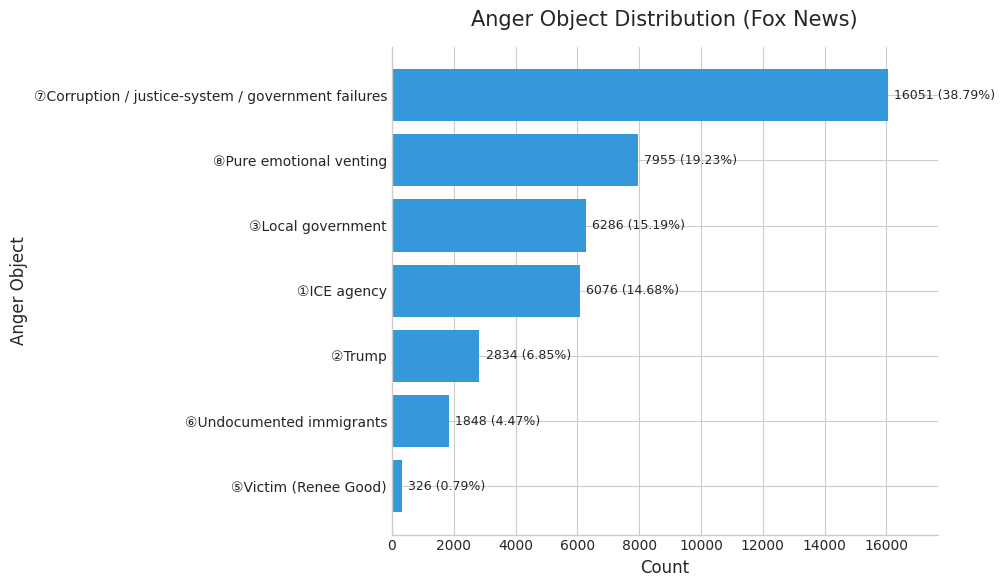

/tmp/ipython-input-2168707791.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stance_df['ice_stance_fixed'], rotation=15, ha='right')


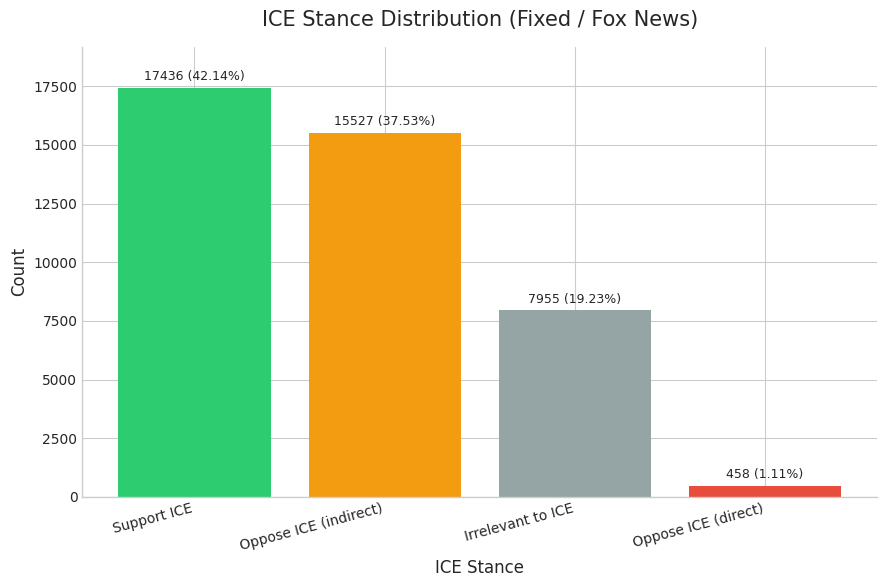

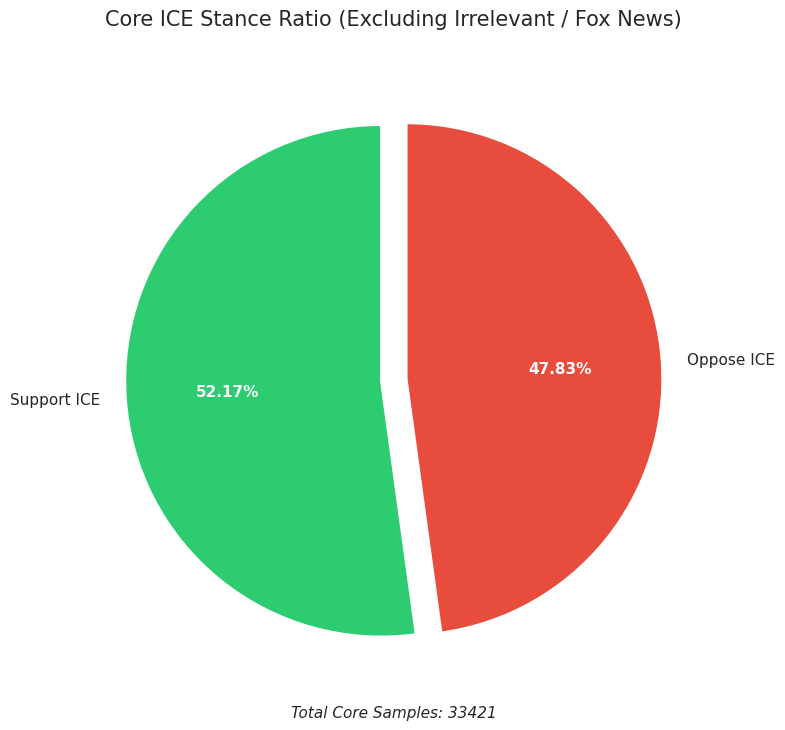

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set global style (professional and clean)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# ========================
# 1. Anger Object Distribution (Horizontal Bar Chart)
# ========================
# Construct anger object data (from your statistics)
anger_obj_data = {
    'anger_object': [
        '⑦Corruption / justice-system / government failures',
        '⑧Pure emotional venting',
        '③Local government',
        '①ICE agency',
        '②Trump',
        '⑥Undocumented immigrants',
        '⑤Victim (Renee Good)'
    ],
    'count': [16051, 7955, 6286, 6076, 2834, 1848, 326],
    'pct(%)': [38.79, 19.23, 15.19, 14.68, 6.85, 4.47, 0.79]
}
obj_df = pd.DataFrame(anger_obj_data).sort_values('count', ascending=True)

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(obj_df['anger_object'], obj_df['count'], color='#3498db')

# Add value labels (count + percentage)
for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = obj_df['pct(%)'].iloc[i]
    ax.text(width + 200, bar.get_y() + bar.get_height()/2,
            f'{int(width)} ({pct}%)', va='center', fontsize=9)

# Set title and labels
ax.set_title('Anger Object Distribution (Fox News)', fontsize=15, pad=15)  # Modified to Fox News
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Anger Object', fontsize=12)
ax.set_xlim(0, max(obj_df['count']) * 1.1)  # Leave space for labels

plt.tight_layout()
plt.savefig('anger_object_distribution_fox_news.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================
# 2. Fixed ICE Stance Distribution (Vertical Bar Chart)
# ========================
# Construct ICE stance data (from your statistics)
stance_data = {
    'ice_stance_fixed': ['Support ICE', 'Oppose ICE (indirect)', 'Irrelevant to ICE', 'Oppose ICE (direct)'],
    'count': [17436, 15527, 7955, 458],
    'pct(%)': [42.14, 37.53, 19.23, 1.11]
}
stance_df = pd.DataFrame(stance_data)

# Define color palette (consistent with previous style)
color_map = {
    'Support ICE': '#2ecc71',
    'Oppose ICE (indirect)': '#f39c12',
    'Irrelevant to ICE': '#95a5a6',
    'Oppose ICE (direct)': '#e74c3c'
}
colors = [color_map[s] for s in stance_df['ice_stance_fixed']]

# Plot vertical bar chart
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.bar(stance_df['ice_stance_fixed'], stance_df['count'], color=colors)

# Add value labels (count + percentage) - Fixed IndexError
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = stance_df['pct(%)'].iloc[i]
    ax.text(bar.get_x() + bar.get_width()/2, height + 200,
            f'{int(height)} ({pct}%)', ha='center', va='bottom', fontsize=9)

# Set title and labels
ax.set_title('ICE Stance Distribution (Fixed / Fox News)', fontsize=15, pad=15)  # Added Fox News
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('ICE Stance', fontsize=12)
ax.set_ylim(0, max(stance_df['count']) * 1.1)  # Leave space for labels
ax.set_xticklabels(stance_df['ice_stance_fixed'], rotation=15, ha='right')

plt.tight_layout()
plt.savefig('ice_stance_distribution_fixed_fox_news.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================
# 3. Core ICE Stance Ratio (Pie Chart, Excluding Irrelevant)
# ========================
# Construct core stance data (from your statistics)
core_data = {
    'stance': ['Support ICE', 'Oppose ICE'],
    'count': [17436, 15985],  # 15527+458=15985
    'pct(%)': [52.17, 47.83]
}
core_df = pd.DataFrame(core_data)

# Define color palette
core_colors = ['#2ecc71', '#e74c3c']

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    core_df['count'],
    labels=core_df['stance'],
    colors=core_colors,
    autopct='%1.2f%%',
    startangle=90,
    explode=(0.05, 0.05),  # Slight explode effect
    textprops={'fontsize': 11},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# Beautify percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Add total sample size annotation
ax.text(0, -1.3, f'Total Core Samples: 33421', ha='center', va='center', fontsize=11, style='italic')

# Set title
ax.set_title('Core ICE Stance Ratio (Excluding Irrelevant / Fox News)', fontsize=15, pad=15)  # Added Fox News
ax.axis('equal')  # Ensure pie chart is a perfect circle

plt.tight_layout()
plt.savefig('core_ice_stance_ratio_fox_news.png', dpi=300, bbox_inches='tight')
plt.show()